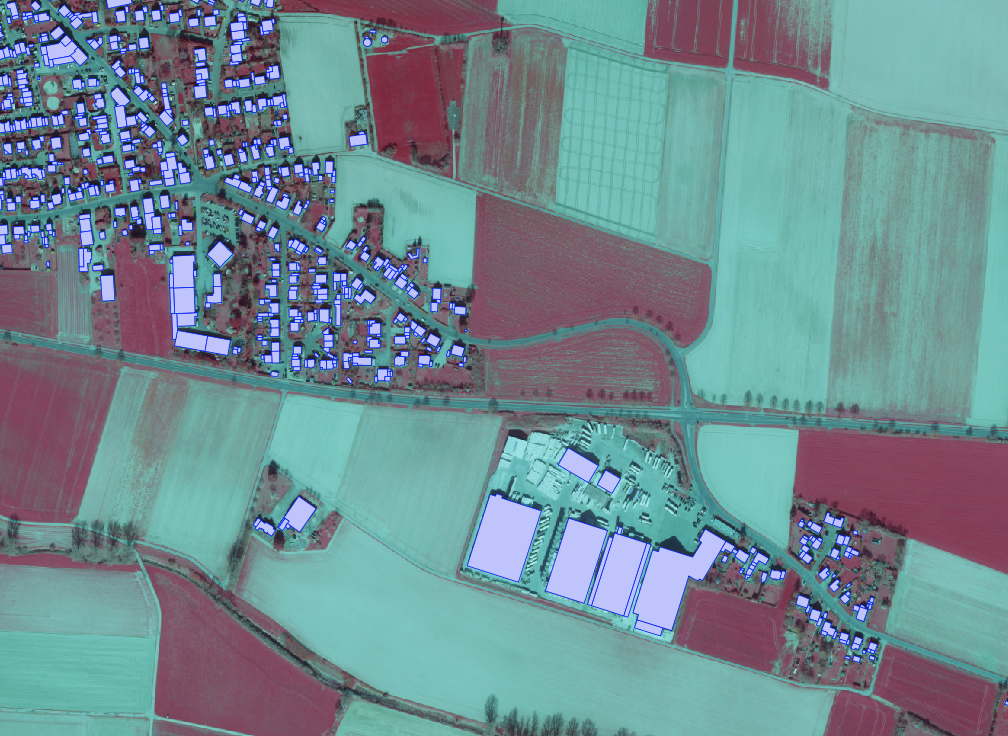

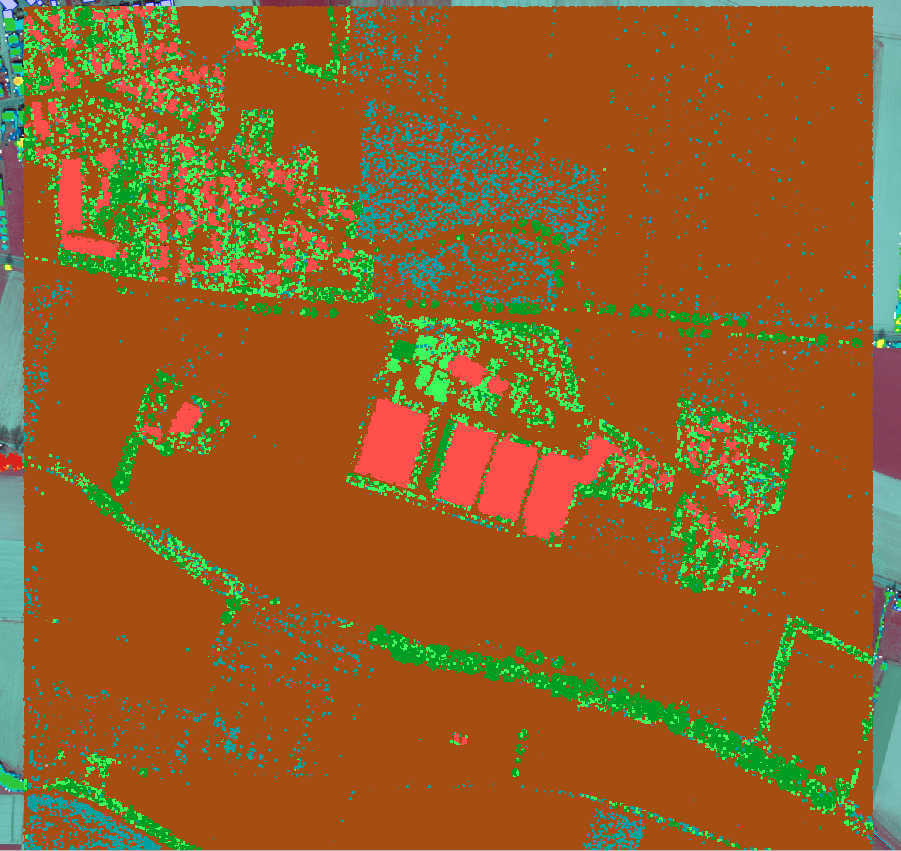

38.699997
Original tiff:


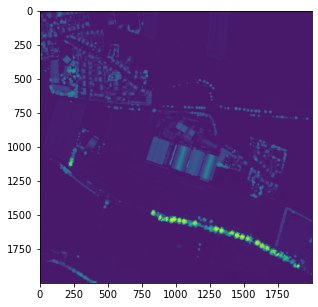

Theshold= 30
Geglättet:


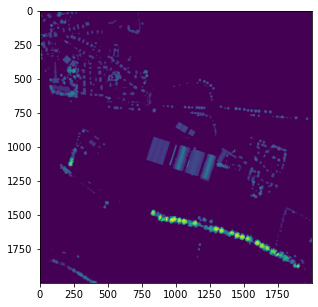

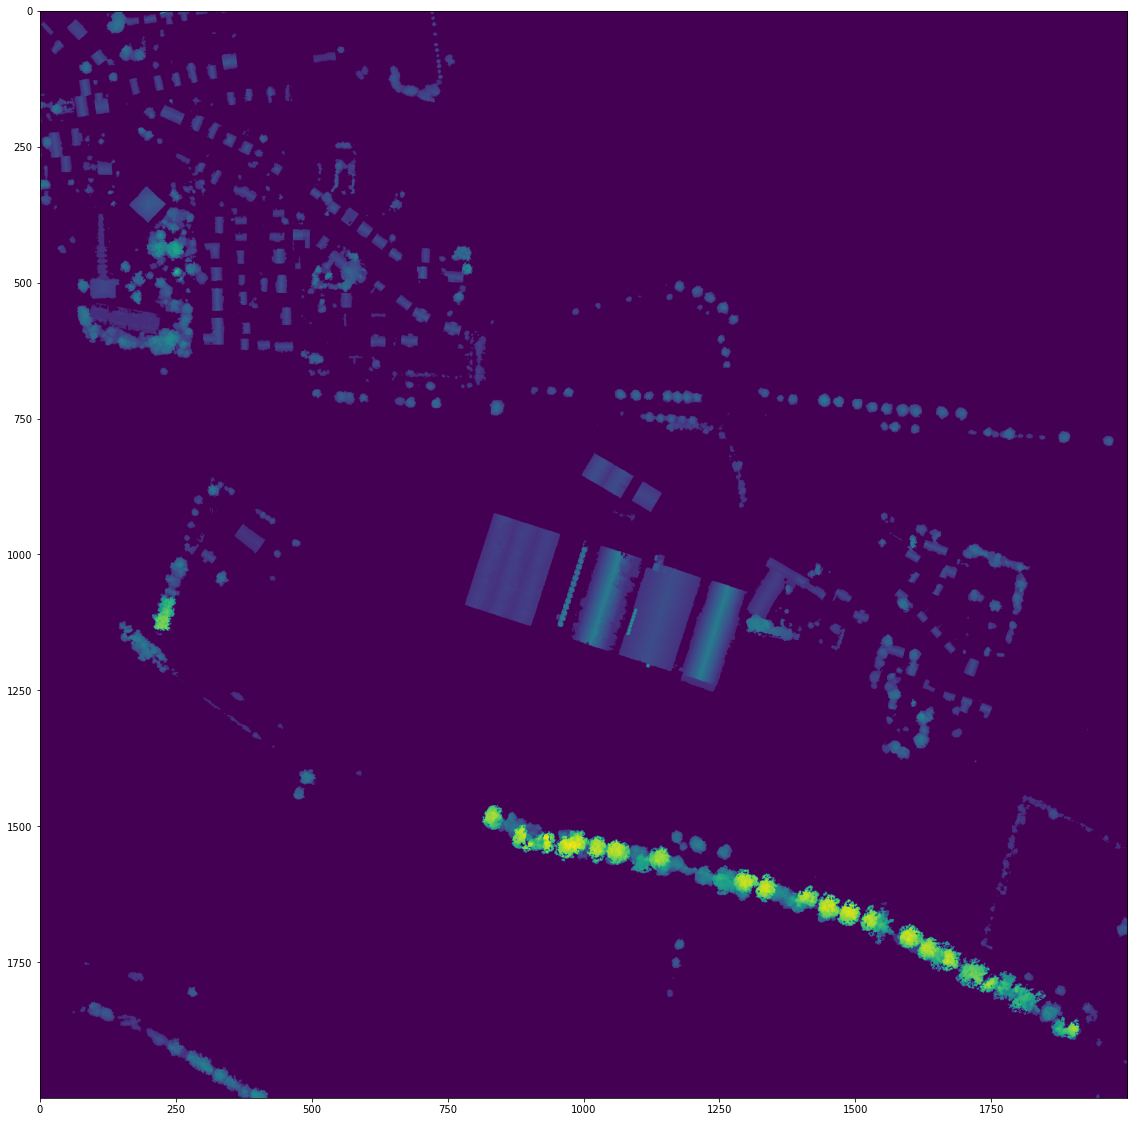

In [1]:
from scipy import ndimage as ndi
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import img_as_float
from PIL import Image
import numpy
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline  
from tqdm import tqdm
#ganz schlecht klassifiziet:3dm_32_330_5726_1_nw.las

las_files=["ccc_3dm_32_330_5723_1_nw.las", "3dm_32_331_5722_1_nw.las","3dm_32_338_5725_1_nw.las", "3dm_32_337_5727_1_nw.las", "3dm_32_337_5726_1_nw.las","3dm_32_337_5725_1_nw.las"]
folder = "lidar-files/test"
las_file = folder+ "/" + las_files[0]

#setze größe der geplotteten bilder:
plt.rcParams['figure.figsize'] = [5, 5]

#lade bild als numpy.array
bdom_file = "ndom50_32330_5723_1_nw_2018.tif"
im = numpy.array(Image.open(bdom_file))
#scaliere in pixel-werte größer 0
m = - numpy.min(im)
#im = im + m

#scaliere in range(0,255) und als integer-array:
m = numpy.max(im)
print(m)
im = ((im/m) *255).astype(numpy.int32)

print("Original tiff:")
plt.imshow(im)
plt.show()

#setze alle pixelwerte < thresshold = 0, um den boden zu glätten
#sonst werden bei jeder kleinen bodenwelle lokale maxima gefunden
threshhold =30 #(numpy.max(im) + numpy.min(im)) * 0.03
print("Theshold=", threshhold)
im = numpy.where(im > threshhold, im, 0) # 0.3,
print("Geglättet:")

plt.imshow(im)
plt.show()
##gaussischer filter (falsch!):
#print("Weichzeichnen:")
#im = gaussian_filter(im, sigma=3)
#median filter
#im = median_filter(im, size=2)


#setze größe der geplotteten bilder:
plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(im)
plt.show()


#43 Bäume laut kataster


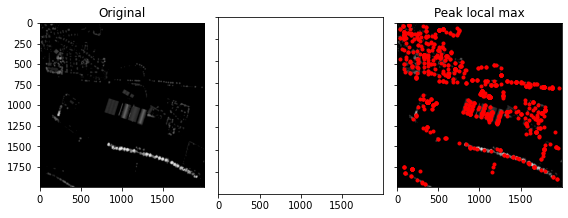

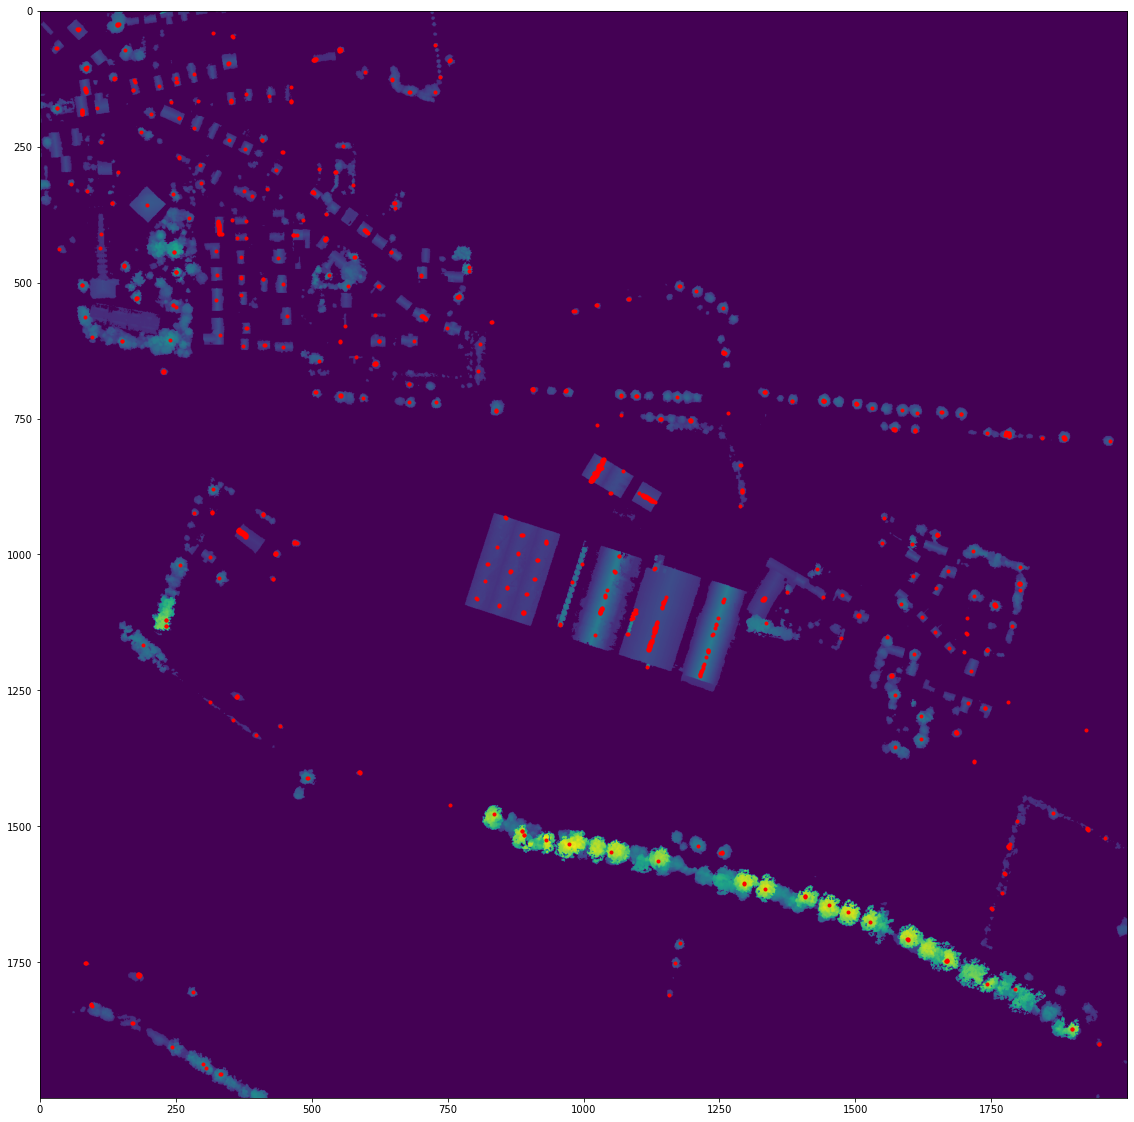

Anzahl Bäume: 1039


In [2]:
#wenn hier die maxima im einfarbigen bereich auftauchen, ist der threshold oben zu niedrig
#hier kann über den min-distance-wert skaliert werden:

min_distance = 25

#image_max = ndi.maximum_filter(im, size=3)   #, mode='constant'
# Comparison between image_max and im to find the coordinates of local maxima
coordinates = []
coordinates = peak_local_max(im, min_distance=min_distance)




# display results:
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].set_title('Original')

#ax[1].imshow(image_max, cmap=plt.cm.gray)
#ax[1].set_title('Maximum filter')

ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].set_title('Peak local max')

fig.tight_layout()

plt.show()

plt.imshow(im)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
plt.show()
print("Anzahl Bäume:", len(coordinates))

In [3]:
import laspy

#las_file = "lidar-files/4merged/Wesel/3dm_32_324_5729_1_nw.laz"
las = laspy.read(las_file)



In [4]:
las_points_x = numpy.array(las.points['x']) 
las_points_y = numpy.array(las.points['y'])
x_max, x_min, y_max, y_min = las_points_x.max(),  las_points_x.min(), las_points_y.max(),  las_points_y.min()
x_range = x_max - x_min
y_range = y_max - y_min
print(x_max, x_min,x_range, y_max, y_min, y_range)

331000.03 329999.96 1000.070000000007 5724000.03 5722999.96 1000.070000000298


In [5]:
import pandas

#koordinaten vom geotiff  bestimmen - > utm koodinate jedes pixels ableiten  - > die coordiates-liste umrechnen 
#- > nächste punkte bestimmen
#load metadata csv
meta_data = pandas.read_csv("metadata/ndom_nw.csv", sep=";")
kachelname = bdom_file.split("/")[-1].split(".")[0]
row = meta_data.loc[meta_data['Kachelname'] == kachelname]

#cpnvert coordinates to ut coords_
x_pixels, y_pixels = im.shape[1],im.shape[0]
step = row['Aufloesung_cm'].values[0]/100  #0.5m per pixel!
utm_coordinates = numpy.zeros((len(coordinates), 2))
for i in range(len(utm_coordinates)):
    utm_coordinates[i][0] = coordinates[i][1] * step + x_min
    utm_coordinates[i][1] = y_max - coordinates[i][0] * step


In [6]:
#check utm_coordinates:
import folium
import coord_f
tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',



lat,long = coord_f.utm_to_lat_long(x_max, y_max)
lat_min,long_min = coord_f.utm_to_lat_long(x_min, y_min)

f_map = folium.Map(location=[lat, long], zoom_start=14)
#add las area:
folium.Marker(location=[lat, long],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat_min, long_min],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat, long_min],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat_min, long],icon=folium.Icon(color="red")).add_to( f_map )

latlong_coordinates = list(map(coord_f.utm_to_lat_long, list(zip(*utm_coordinates))[0],  list(zip(*utm_coordinates))[1]))
#add trees:
for lat, long in latlong_coordinates:
    folium.Marker(location=[lat, long],icon=folium.Icon(color="green")).add_to( f_map )

f_map

In [7]:
from sklearn.cluster import DBSCAN
length = len(las.points['x'])

points_to_cluster = numpy.array([[las.points['x'][i], las.points['y'][i], las.points['z'][i]] for i in tqdm(range(length)) if (las.points['classification'][i] == 5)]) 
indices_of_cluster_points = numpy.array([i for i in tqdm(range(length)) if (las.points['classification'][i] == 5)]) 
cluster = DBSCAN(eps=1, min_samples=10).fit(points_to_cluster)  # parameters according to https://www.degruyter.com/document/doi/10.1515/geo-2020-0266/html?lang=de
labels = cluster.labels_
for i, l in tqdm(zip(indices_of_cluster_points, labels)):
    if l == -1:
        las.points['classification'][i] = 1 



100%|██████████| 9805369/9805369 [02:03<00:00, 79263.60it/s]
804882it [00:01, 471007.55it/s]


In [8]:
from scipy.spatial import distance
#find list of nearest points in las:    
centroids_in_las = numpy.zeros((len(utm_coordinates), 3))
z =numpy.max(numpy.array(las.points['z']))

las_points = numpy.array((las.points['x'], las.points['y'],las.points['z'])).transpose()  #hier noch nach classification filtern!
print(las_points)
for i in tqdm(range(len(utm_coordinates) -1, -1, -1 )):
        coord = [utm_coordinates[i][0], utm_coordinates[i][1], z]
        closest_index = int(distance.cdist([coord], las_points).argmin())
        c = las.points['classification'][closest_index]
        if c in [5]:
            centroids_in_las[i] = las.points['x'][closest_index], las.points['y'][closest_index], las.points['z'][closest_index]
        else:
            centroids_in_las = numpy.delete(centroids_in_las, i,  axis=0)
print(centroids_in_las)

print(len(centroids_in_las))

[[3.30008000e+05 5.72300008e+06 1.54300000e+01]
 [3.30011310e+05 5.72300013e+06 1.54700000e+01]
 [3.30009510e+05 5.72300010e+06 1.57000000e+01]
 ...
 [3.30999330e+05 5.72399737e+06 2.01100000e+01]
 [3.30999030e+05 5.72399962e+06 2.00700000e+01]
 [3.30999600e+05 5.72399809e+06 2.00900000e+01]]


100%|██████████| 1039/1039 [01:29<00:00, 11.57it/s]

[[3.30167210e+05 5.72302257e+06 3.19400000e+01]
 [3.30167210e+05 5.72302257e+06 3.19400000e+01]
 [3.30152800e+05 5.72302725e+06 3.23200000e+01]
 ...
 [3.30072960e+05 5.72398787e+06 3.54300000e+01]
 [3.30072960e+05 5.72398787e+06 3.54300000e+01]
 [3.30072960e+05 5.72398787e+06 3.54300000e+01]]
425


In [9]:
lat,long = coord_f.utm_to_lat_long(x_max, y_max)
lat_min,long_min = coord_f.utm_to_lat_long(x_min, y_min)

f_map = folium.Map(location=[lat, long], zoom_start=14)
#add las area:
folium.Marker(location=[lat, long],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat_min, long_min],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat, long_min],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat_min, long],icon=folium.Icon(color="red")).add_to( f_map )

latlong_coordinates = list(map(coord_f.utm_to_lat_long, list(zip(*centroids_in_las))[0],  list(zip(*centroids_in_las))[1]))
#add trees:
for lat, long in latlong_coordinates:
    folium.Marker(location=[lat, long],icon=folium.Icon(color="green")).add_to( f_map )

f_map

0 Nie klassifiziert
1 Nicht zugewiesen
2 Oberfläche
3 Niedrige Vegetation
4 Mittelhohe Vegetation
5 Hohe Vegetation
6 Gebäude
7 Tiefpunkt
8 Reserviert
9 Wasser
10 Schienen
11 Straßenbelag
12 Reserviert
13 Schutzdraht (Schild)
14 Drahtleiter (Phase)
15 Strommast
16 Leitungsverbinder (Isolator)
17 Brückenfahrbahn
18 Hohes Rauschen

In [10]:
import clustering
used_classifications = [5]
points_to_cluster = numpy.array([[las.points['x'][i], las.points['y'][i], las.points['z'][i]] for i in tqdm(range(len(las.points['x']))) if (las.points['classification'][i] in used_classifications)]) 
#geht das mit fiter vielleicht schneller? 1:30 ist viel zu langsam..

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


100%|██████████| 9805369/9805369 [02:15<00:00, 72172.72it/s]


In [11]:
#print(centroids_in_las)
print(points_to_cluster)

clustering.k_means_no_dbscan(centroids_in_las, points_to_cluster, 1)

[[3.30159630e+05 5.72301367e+06 2.09000000e+01]
 [3.30160010e+05 5.72301333e+06 2.11000000e+01]
 [3.30157050e+05 5.72301996e+06 1.89700000e+01]
 ...
 [3.30986390e+05 5.72360322e+06 2.83000000e+01]
 [3.30986640e+05 5.72360365e+06 2.54500000e+01]
 [3.30986510e+05 5.72360311e+06 2.50000000e+01]]
starting k-means:


C:\Users\janja\Desktop\GitHub\lidar-vegetation-data\clustering.py:146: ConvergenceWarning: Number of distinct clusters (424) found smaller than n_clusters (425). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=len(centroids) , max_iter=iterations,init=centroids, n_init=1, tol=0.01).fit(points_to_cluster)


finish!


100%|██████████| 425/425 [00:00<00:00, 107364.89it/s]


label_colors (425, 3)


100%|██████████| 740212/740212 [00:01<00:00, 562065.55it/s]


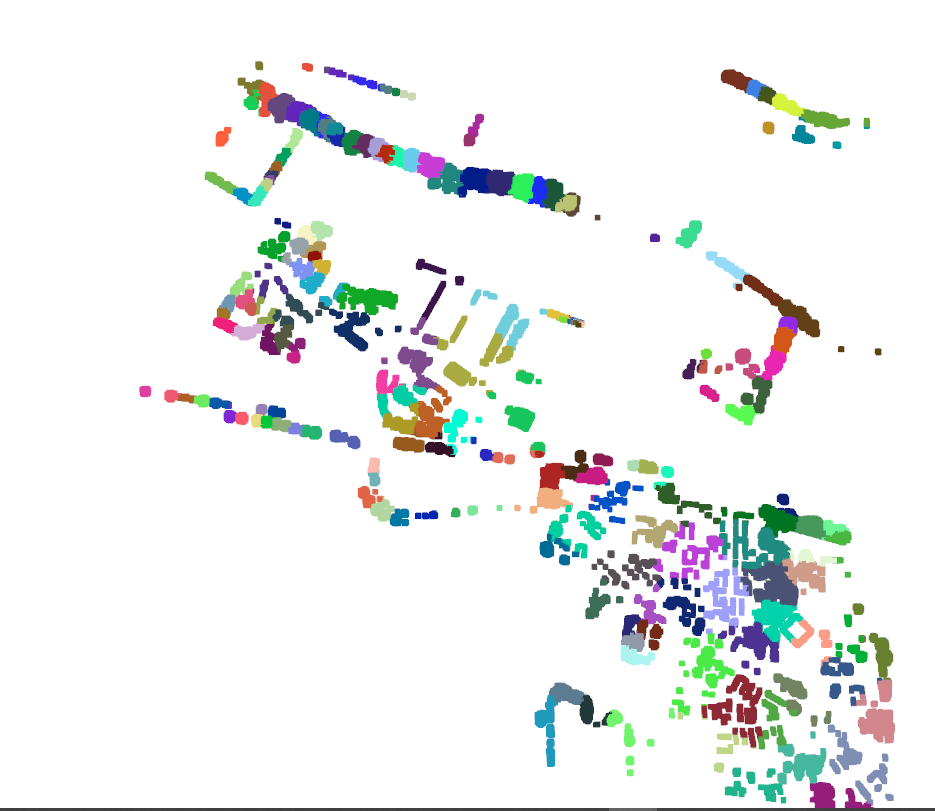

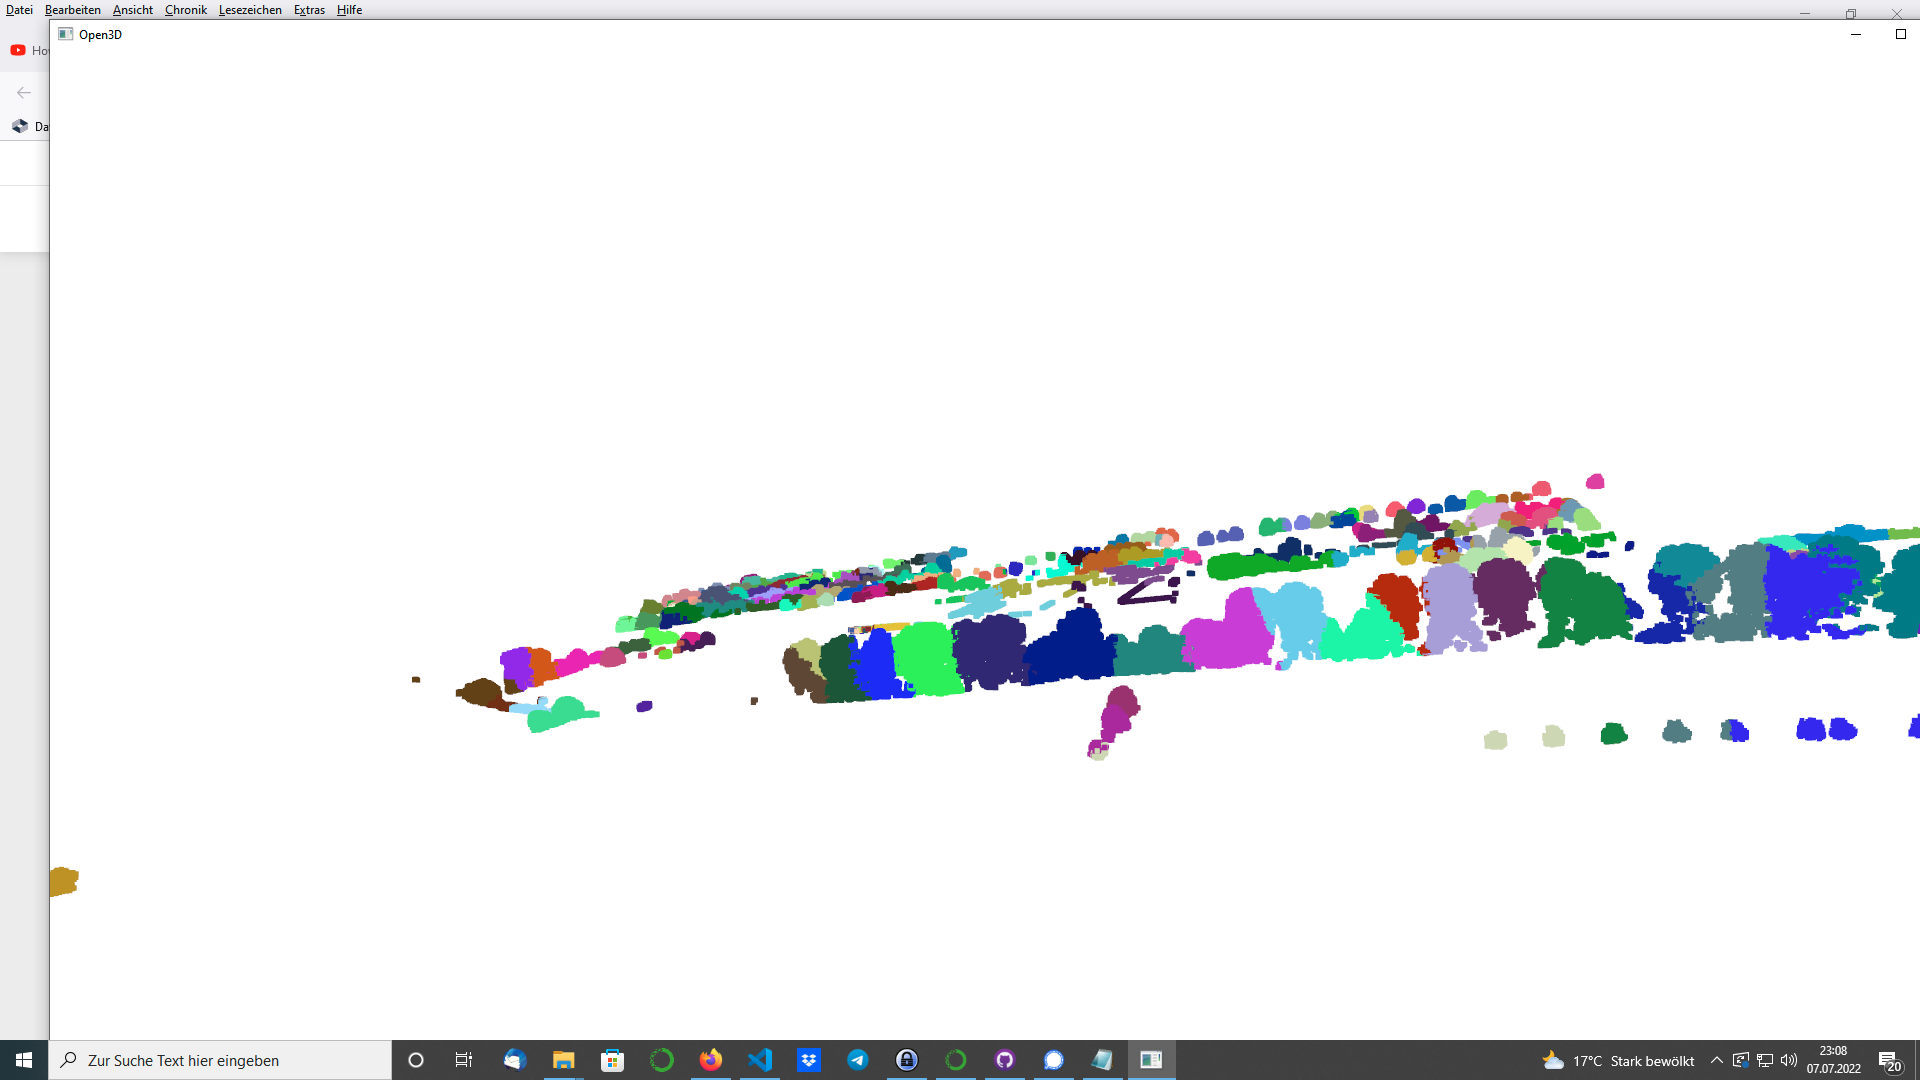

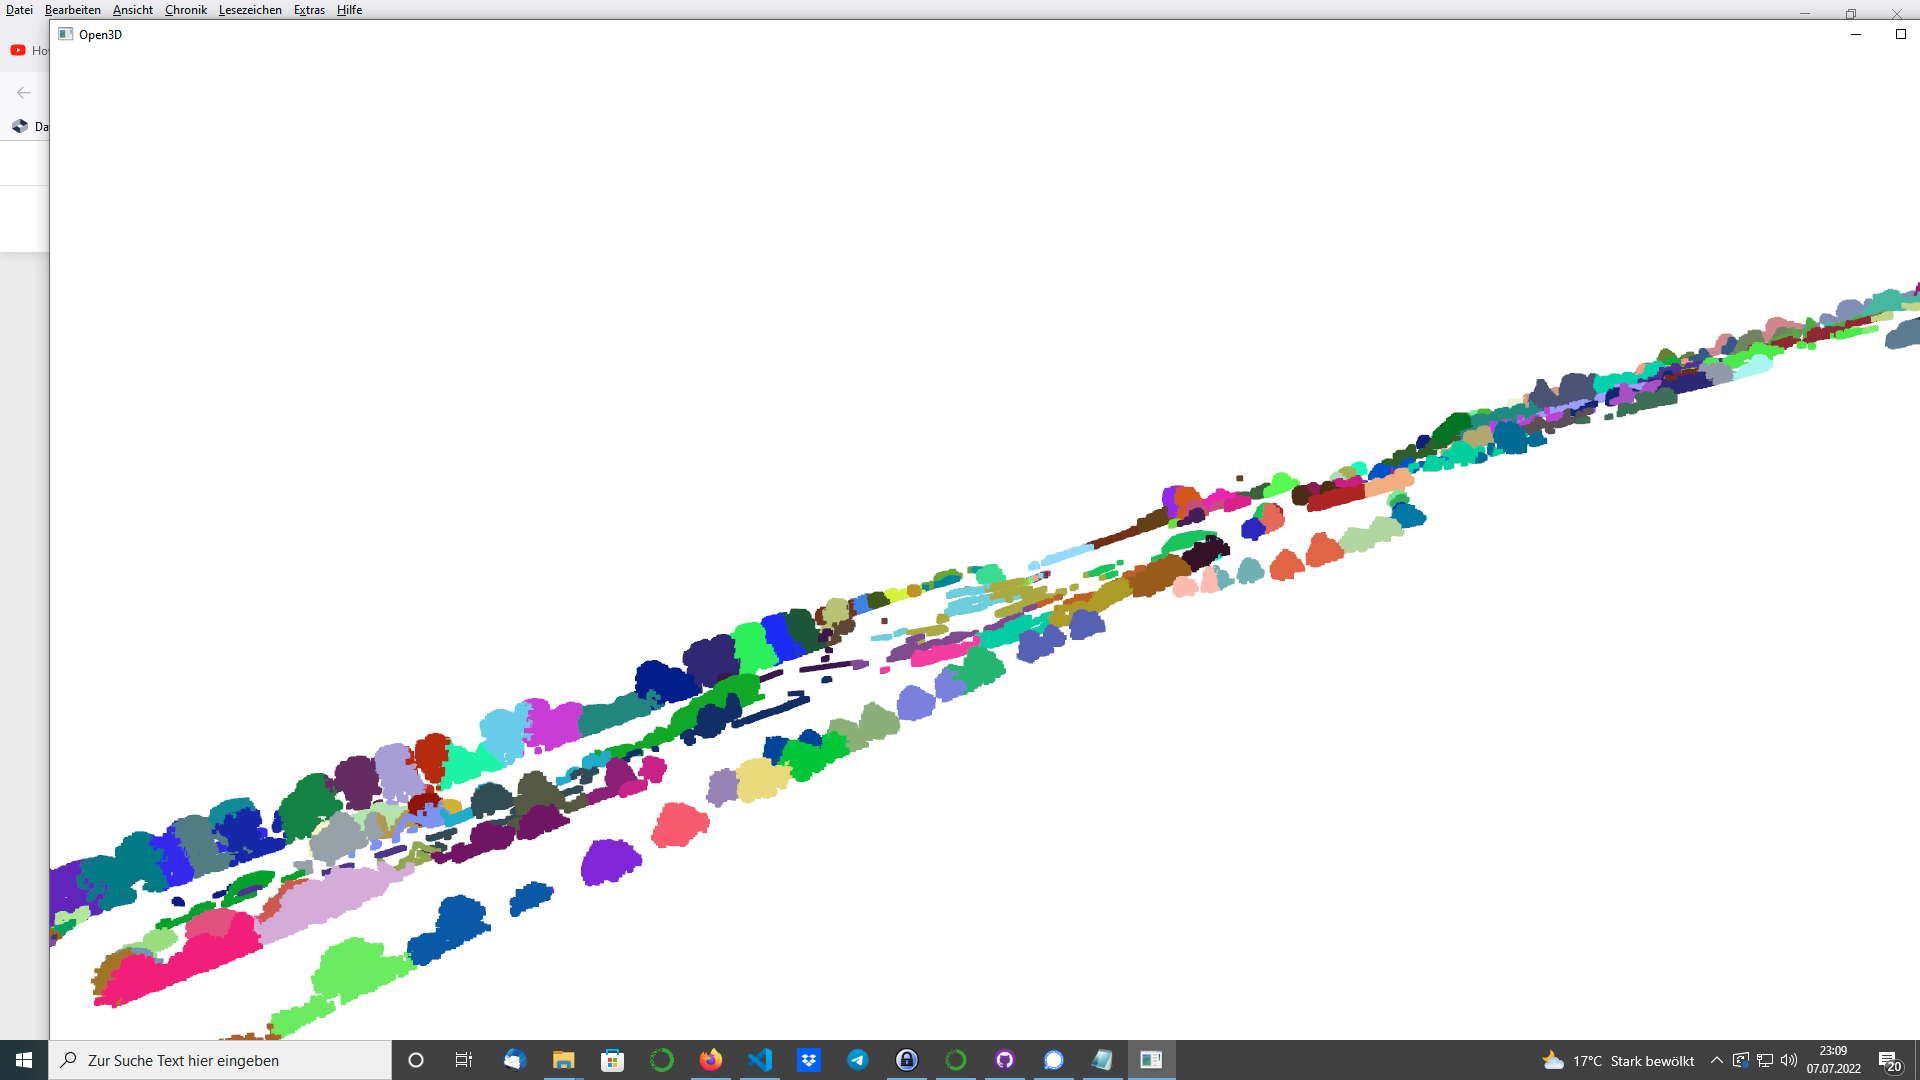

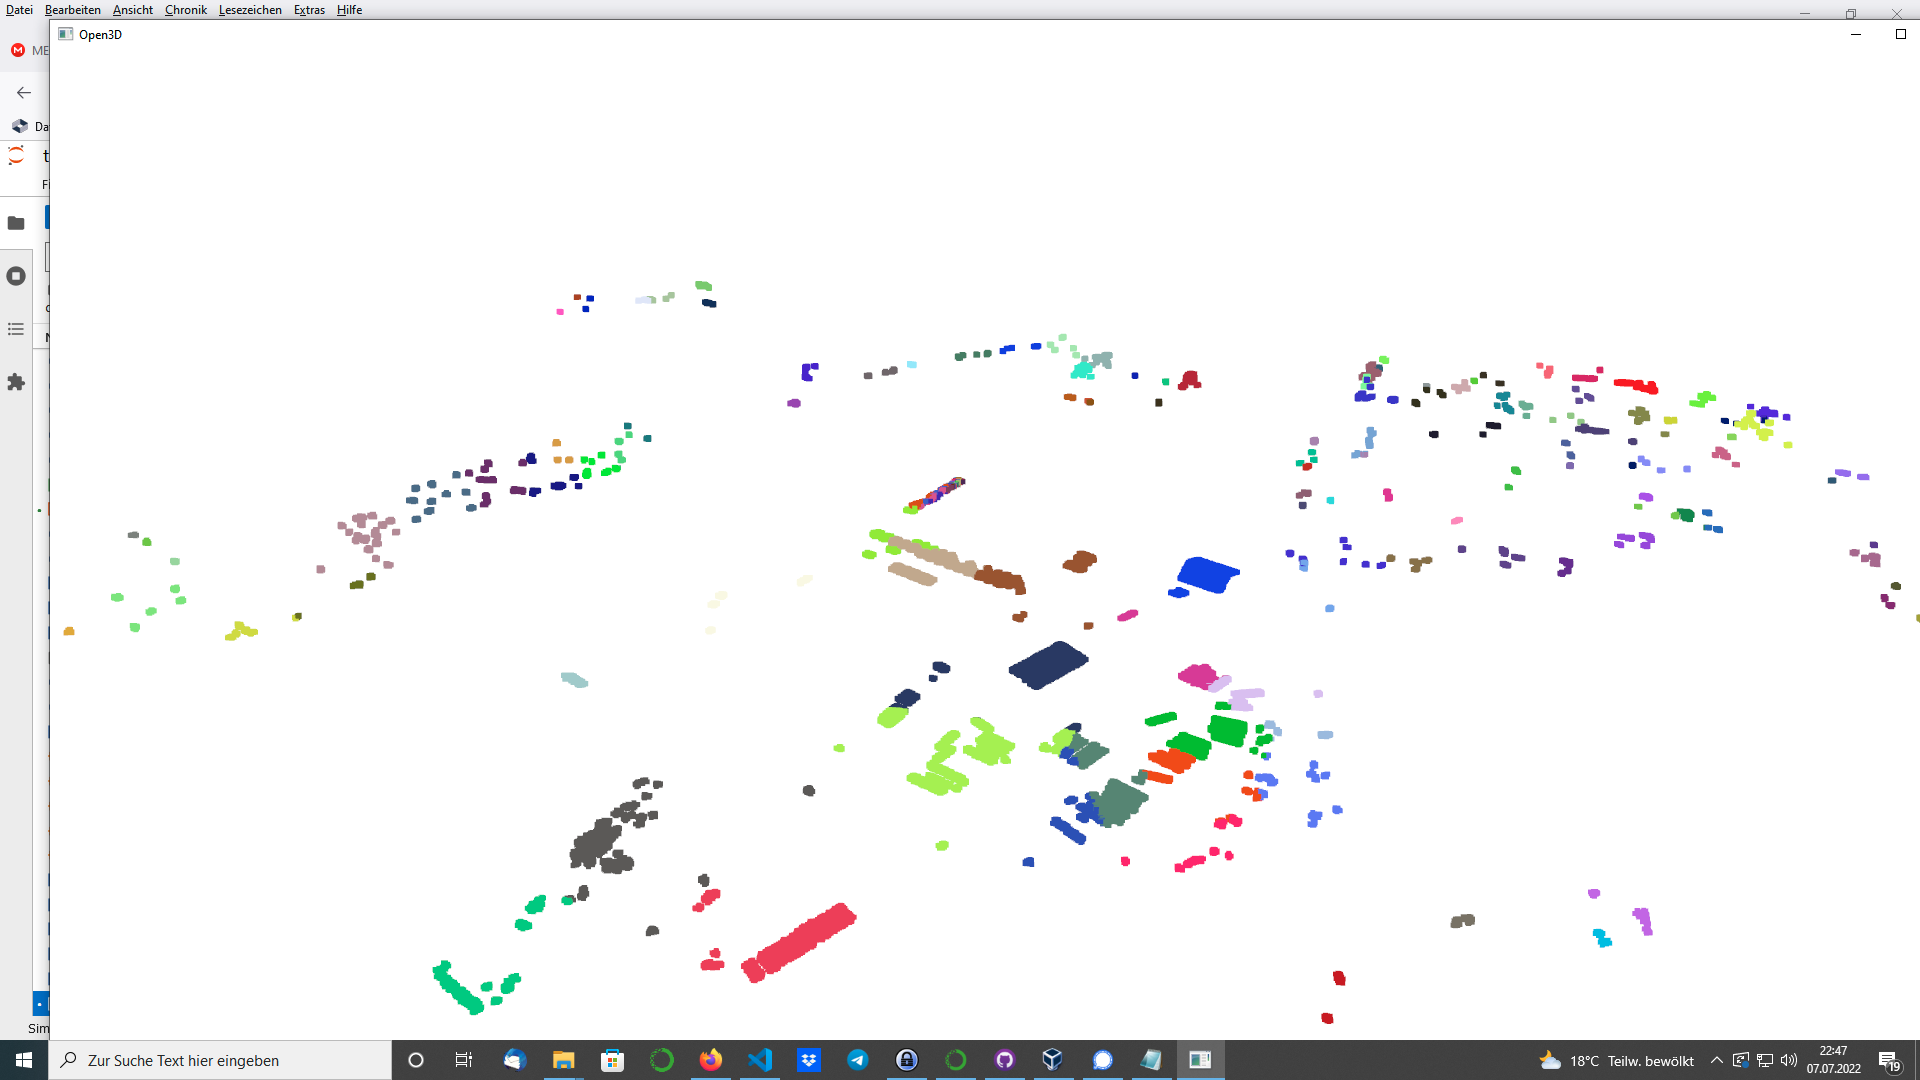